In [7]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import torch
import torch.autograd as autograd
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence,pack_padded_sequence,pack_sequence,pad_packed_sequence

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

from multiprocessing import cpu_count
# import pytorch_lighting as pl
# from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
# from pytorch_lightning.loggers import TensorBoardLogger
# from pytorch_lightning.metrics.functional import accuracy

import librosa
import os

import warnings
warnings.filterwarnings(action = "ignore")

In [8]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

color_palette = ['#01BEFE', '#FFDD00', '#FF7D00', '#FF006D', '#AD006D', '#ADFF02', '#8F00FF']

sns.set_palette(sns.color_palette(color_palette))

rcParams['figure.figsize'] = 16, 10


os.environ['CUDA_VISIBLE_DEVICES'] = '3'
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

## Dataset Overview

In [56]:
train_post_competition = pd.read_csv('train_post_competition.csv')
test_post_competition = pd.read_csv('test_post_competition.csv')
train_post_competition

,fname,label,manually_verified,freesound_id,license
0,00044347.wav,Hi-hat,0,28739,Attribution
1,001ca53d.wav,Saxophone,1,358827,Attribution
2,002d256b.wav,Trumpet,0,10897,Creative Commons 0
3,0033e230.wav,Glockenspiel,1,325017,Attribution
4,00353774.wav,Cello,1,195688,Attribution
...,...,...,...,...,...
9468,ffec59fb.wav,Fireworks,0,343090,Creative Commons 0
9469,fff37590.wav,Hi-hat,0,33136,Attribution
9470,fff44ac6.wav,Laughter,0,133674,Attribution
9471,fff6a13d.wav,Chime,0,14640,Attribution


In [58]:
pd.DataFrame(train_post_competition.label.value_counts())

,label
Hi-hat,300
Laughter,300
Shatter,300
Applause,300
Squeak,300
Acoustic_guitar,300
Bass_drum,300
Saxophone,300
Flute,300
Double_bass,300


<AxesSubplot:>

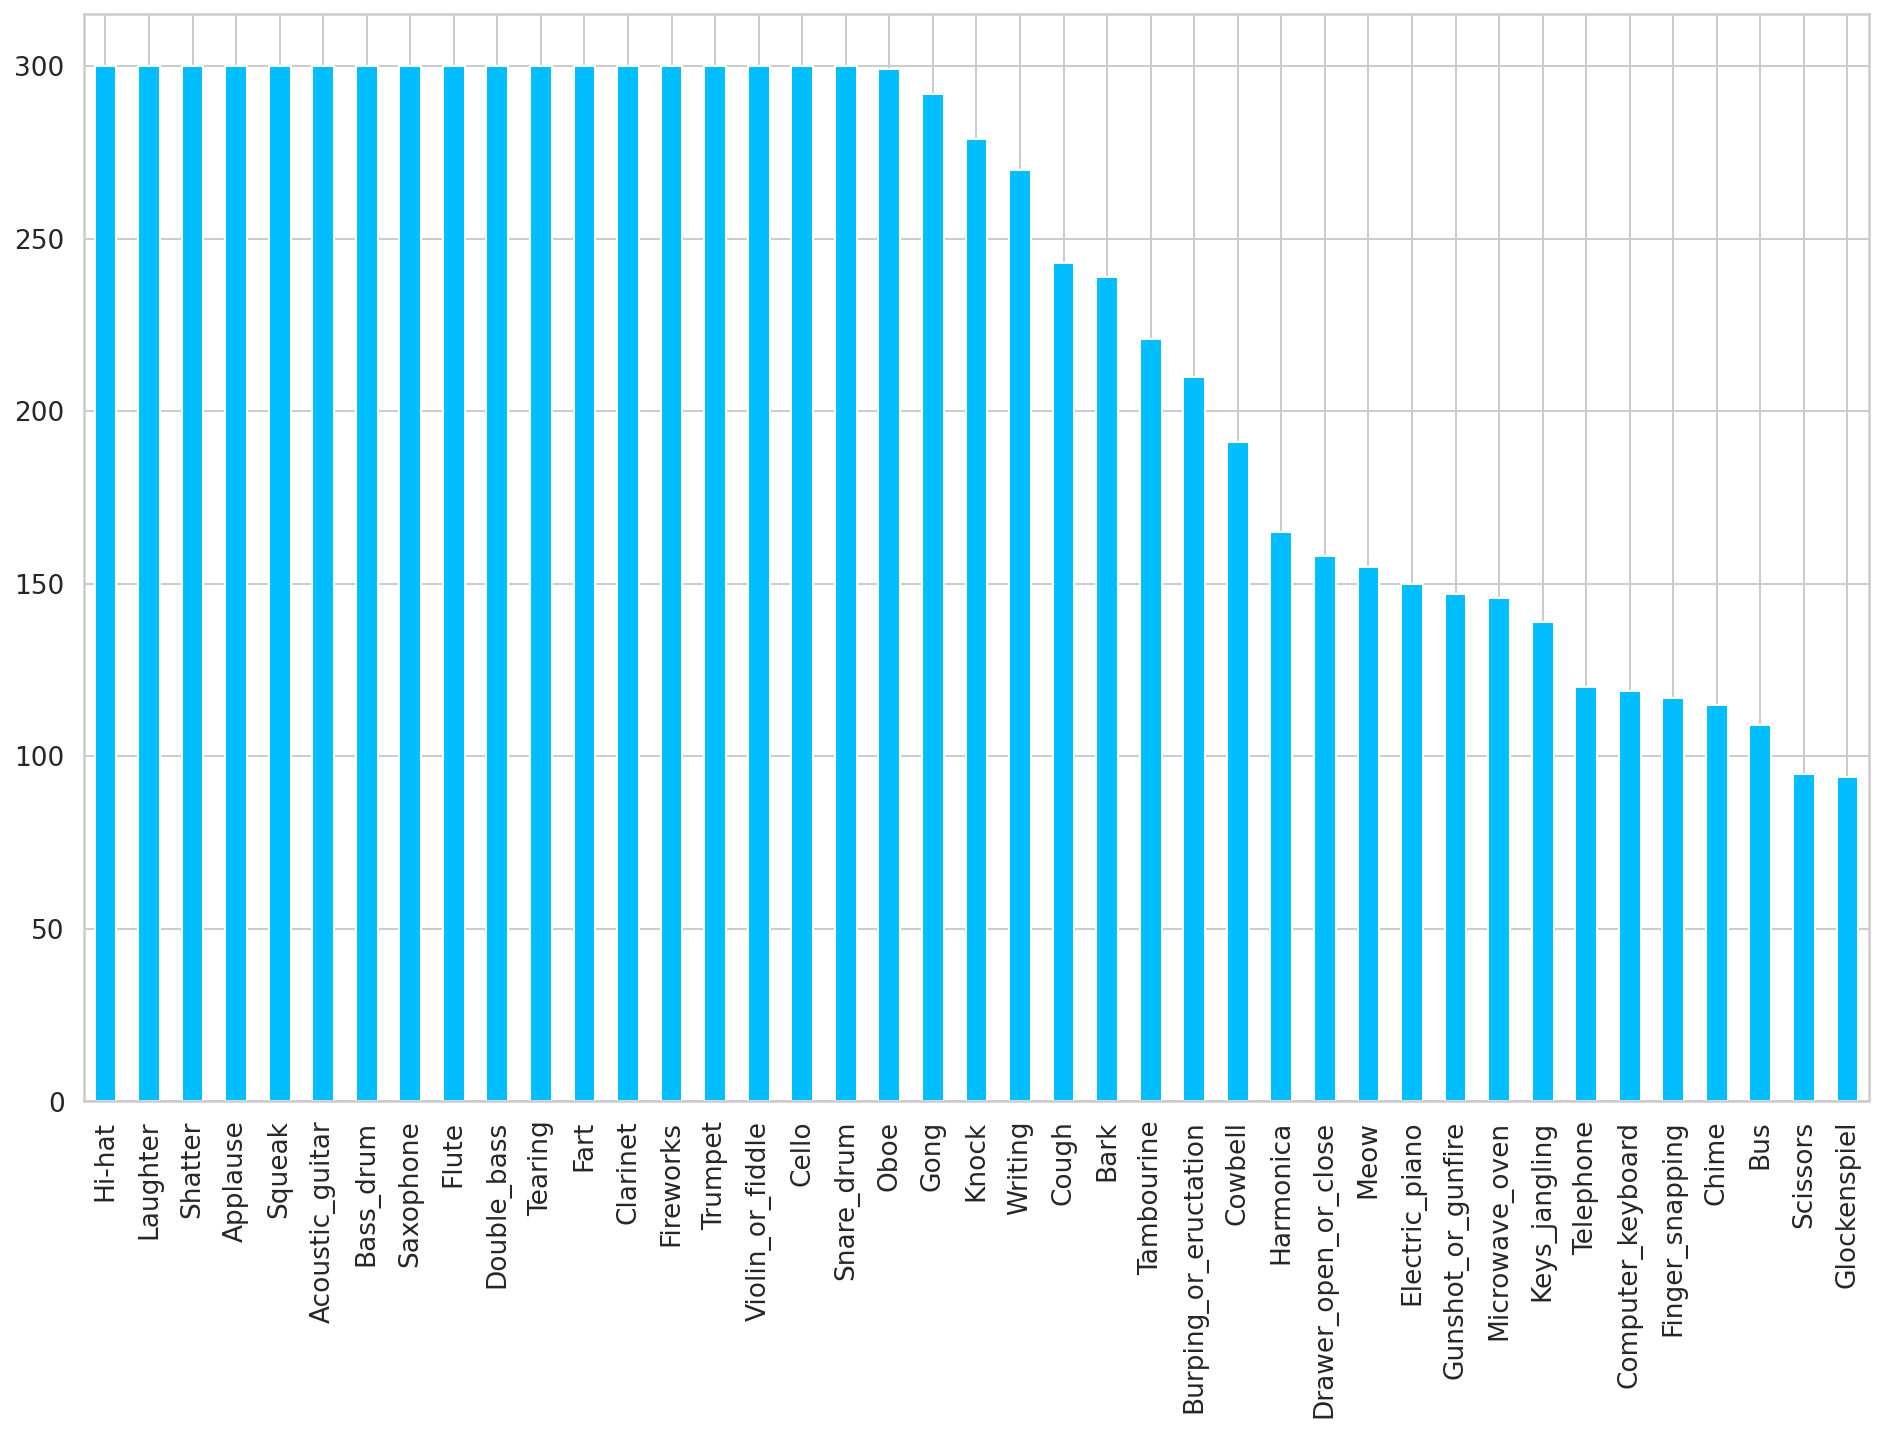

In [11]:
train_post_competition.label.value_counts().plot(kind='bar')

## Load the audio data as a time series using "librosa"

In [52]:
y, sr = librosa.load('audio_train/002d256b.wav', sr=11025)
y, sr

(array([-9.6781314e-06, -3.6996349e-05, -1.4843055e-05, ...,
        -9.9896242e-06, -3.5597372e-05, -2.0594454e-05], dtype=float32),
 11025)

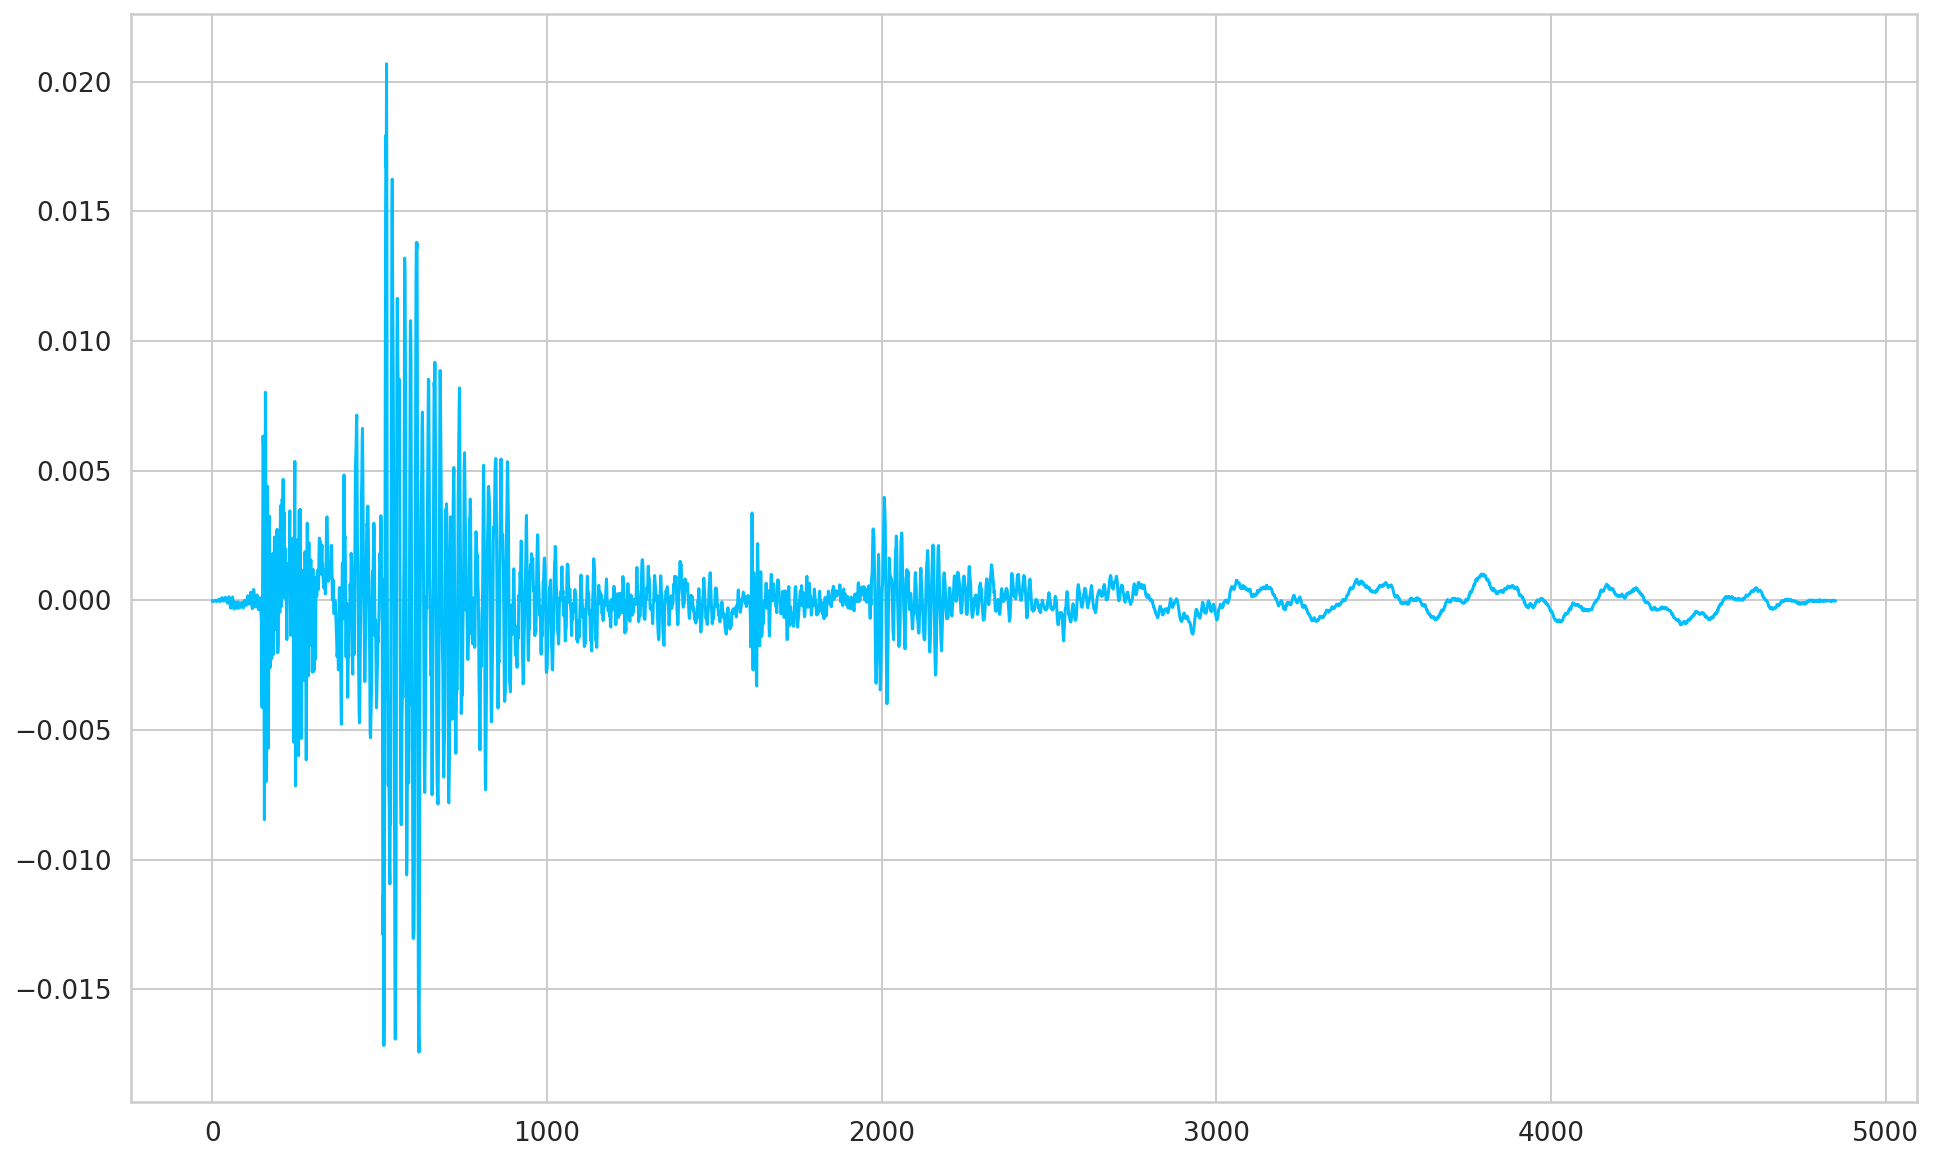

In [53]:
plt.plot(y)

In [54]:
def get_spectrogram(wav):
    D = librosa.stft(wav, n_fft=480, hop_length=160,
                     win_length=480, window='hamming')
    spect, phase = librosa.magphase(D)
    return spect


spectrogram shape: (241, 31)


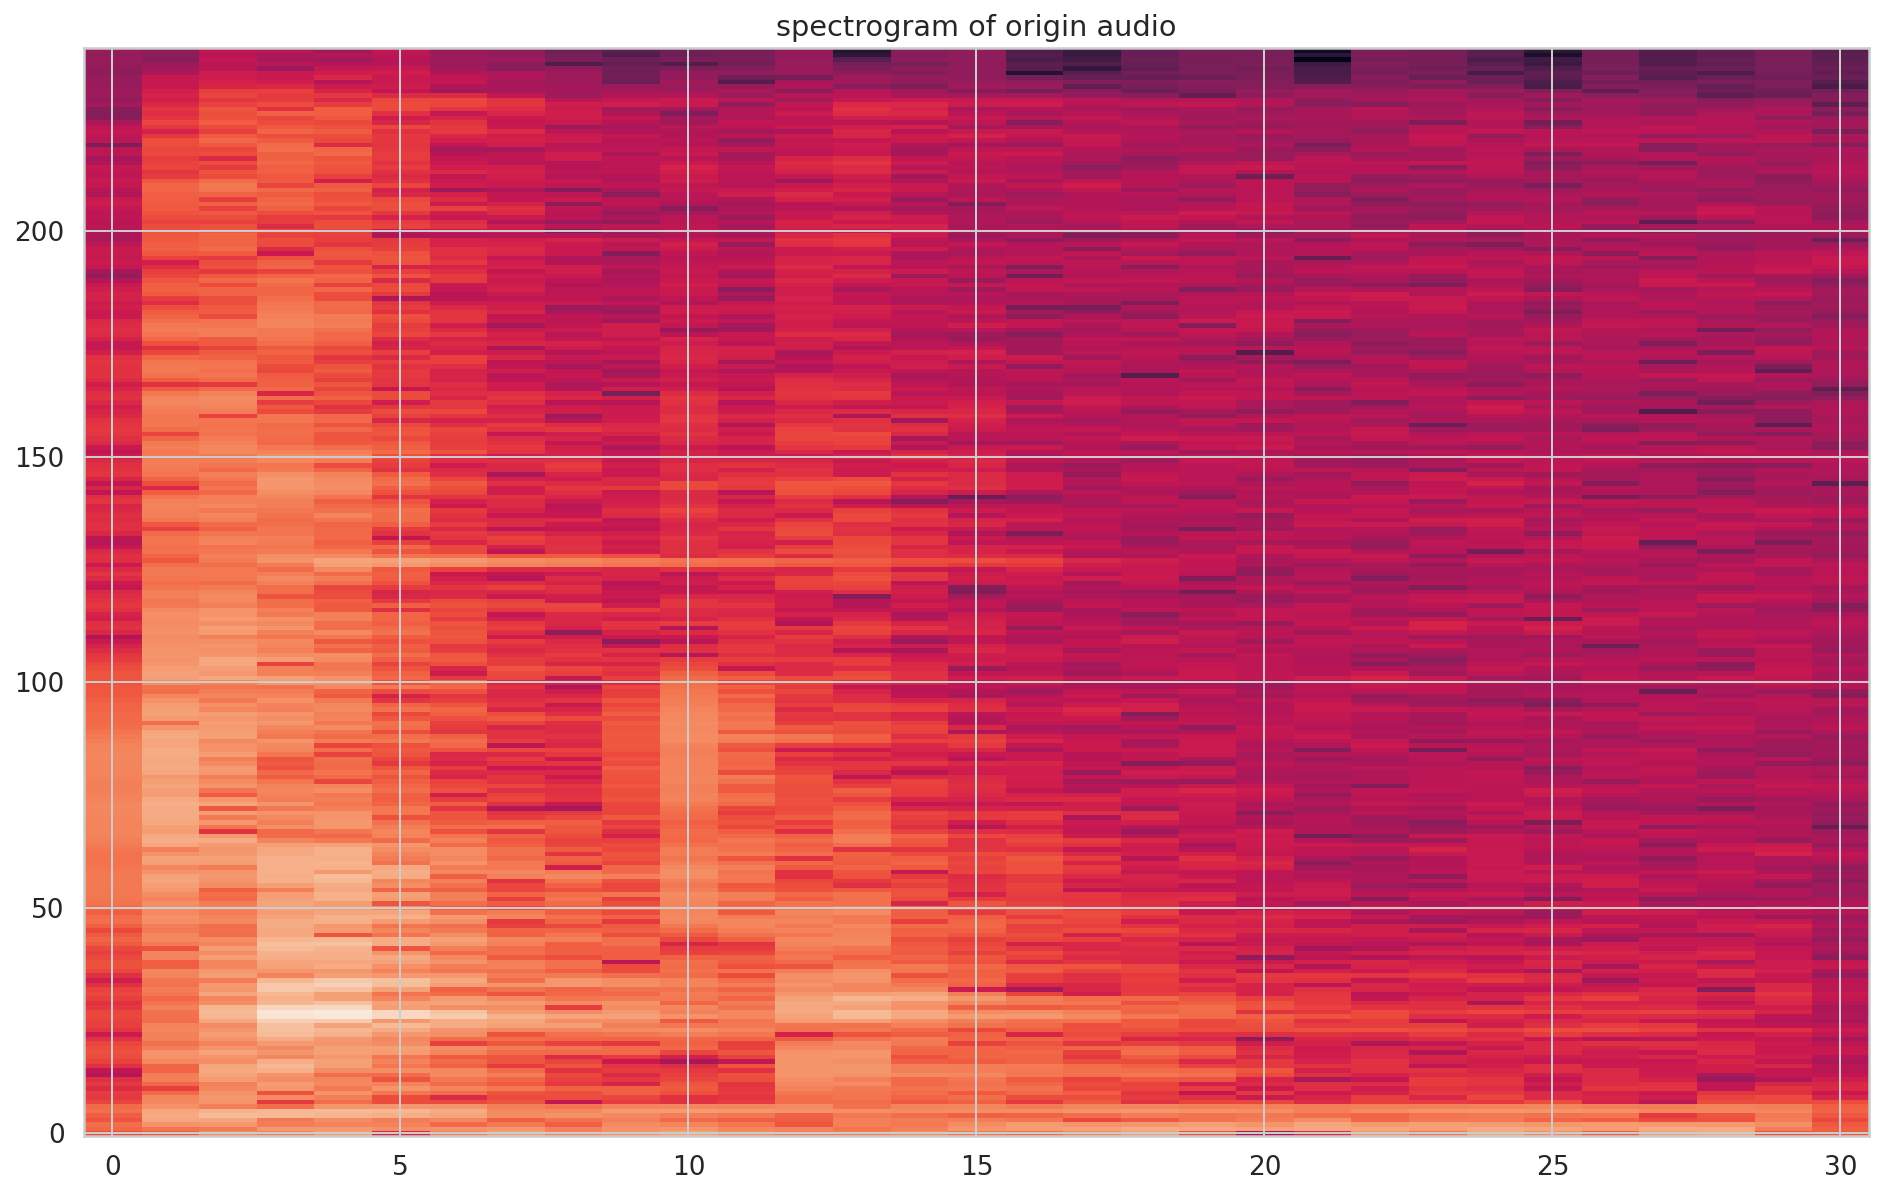

In [55]:
log_spect = np.log(get_spectrogram(y))
print('spectrogram shape:', log_spect.shape)
plt.imshow(log_spect, aspect='auto', origin='lower',)
plt.title('spectrogram of origin audio')
plt.show()

In [51]:
len(y), len(mfccs[0])*24

(4851, 5352)

In [45]:
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=24)
mfccs.T.shape

(223, 24)

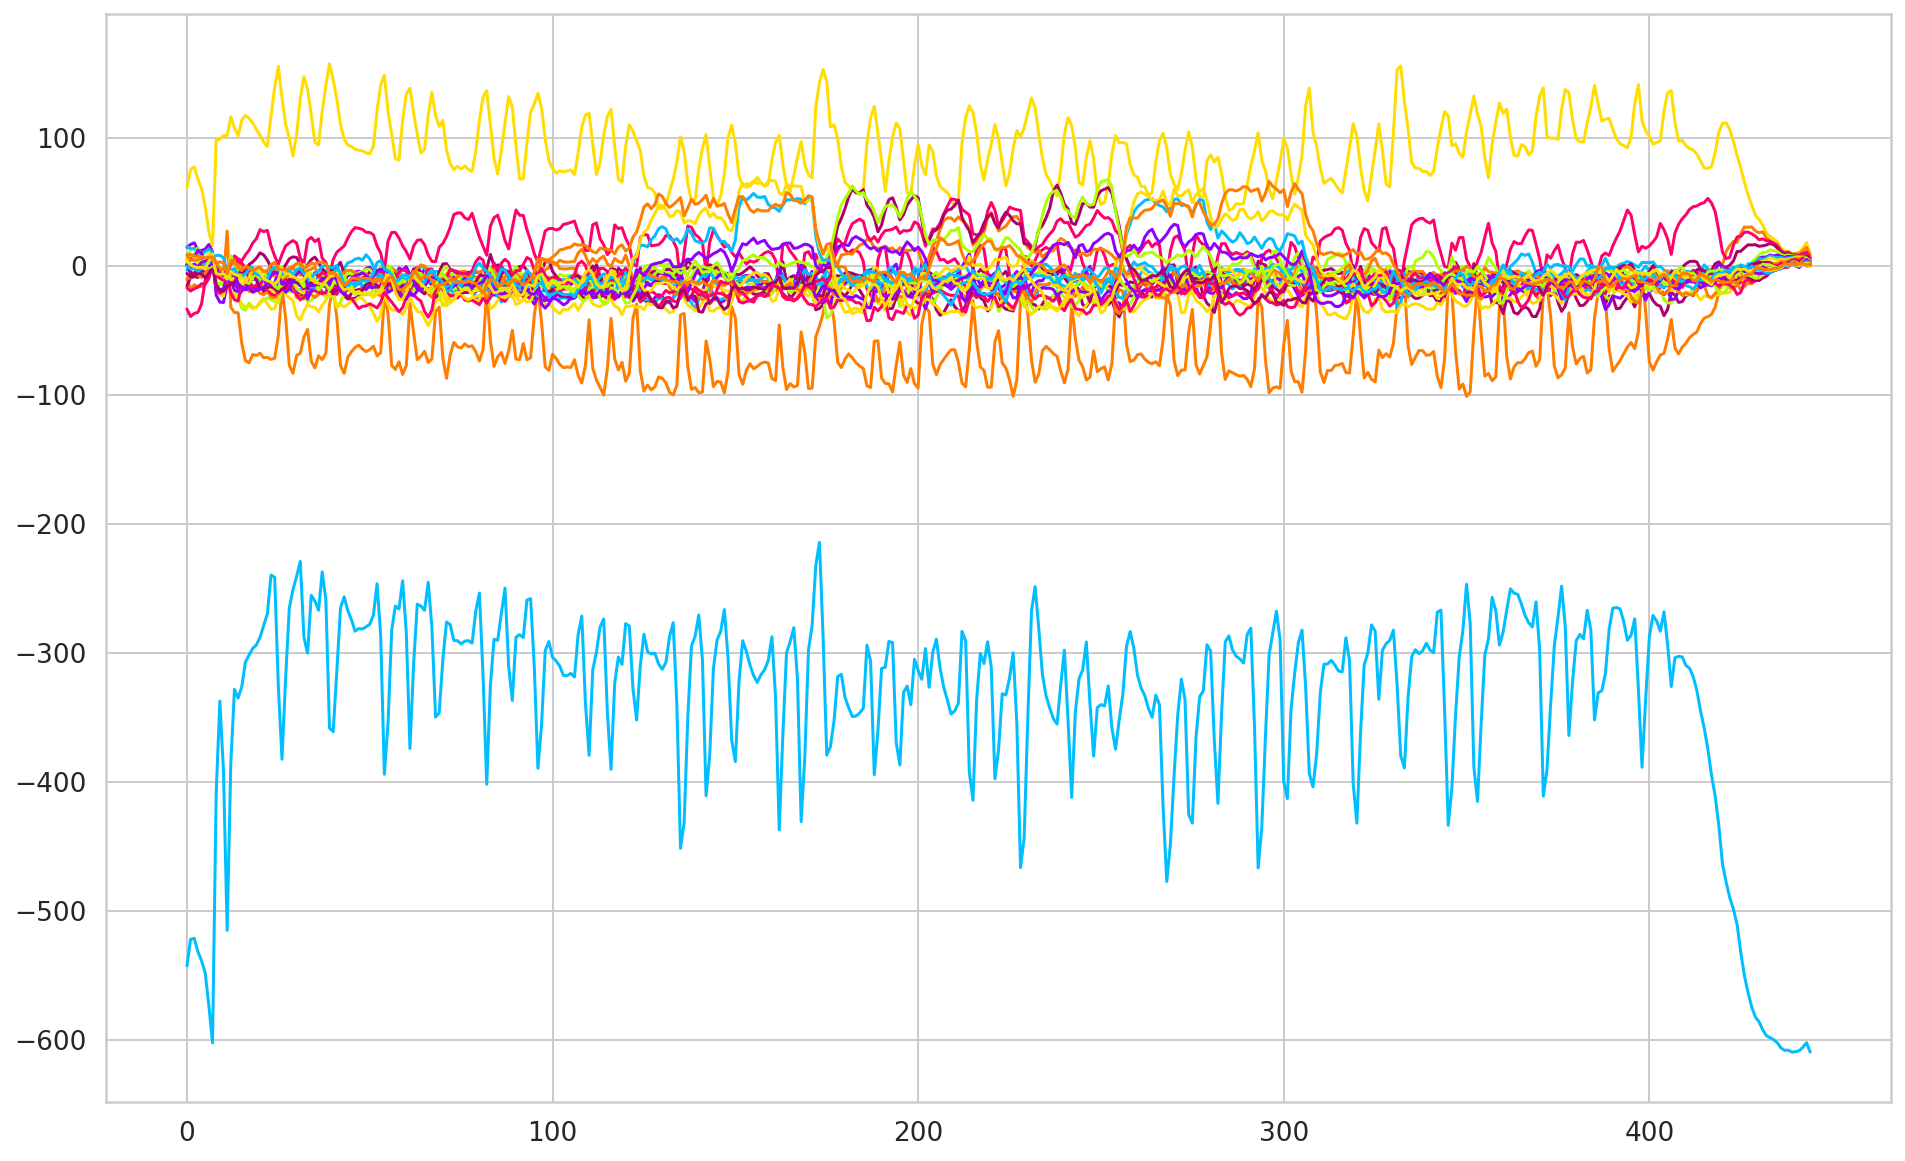

In [38]:
for i in range(len(mfccs)):
    plt.plot(mfccs[i])

In [14]:
train_path = 'audio_train/'
test_path = 'audio_test/'

In [8]:
## check if we need to normalize the time series data. 
## it turns out that the data was normalized already. 

count = 0
for file in train_post_competition['fname']:
    y, _ = librosa.load(os.path.join(train_path,file), sr=11025)
    print(np.min(y), np.max(y), np.mean(y), np.std(y))
    count+=1
    if count>20:
        break

-0.49611205 0.45627564 -2.8424067e-05 0.027702335
-0.3742812 0.47031808 -1.5127393e-05 0.09754871
-0.017417688 0.020687167 -3.528758e-05 0.0019818863
-0.067150004 0.07374627 -2.5007395e-05 0.006563786
-0.37718257 0.36016053 -1.1666928e-06 0.09170972
-0.14369422 0.1453504 -2.8391221e-05 0.052822225
-0.27750173 0.33093083 -1.5326375e-05 0.025375813
-1.0877608 1.1181347 0.00088061637 0.21334618
-0.19492386 0.21665637 -1.6004915e-05 0.080384746
-0.28341696 0.28377503 2.0722962e-05 0.0042322227
-0.1717748 0.17344749 -1.6097427e-05 0.014947064
-0.172354 0.25957704 -1.5452813e-05 0.00394689
-1.0550464 1.0457643 -6.749788e-05 0.14252326
-0.20177403 0.09060329 -1.1353387e-05 0.0041746306
-0.17231977 0.1674854 -1.3471113e-05 0.035932206
-0.58831155 0.8836421 -1.4150612e-05 0.12624906
-0.3377362 0.394734 -6.111642e-05 0.025214013
-0.7351847 0.67514807 -4.0427723e-05 0.039218623
-0.87728477 1.0753171 0.004525866 0.15860498
-0.3358269 0.3946573 -0.00012340749 0.033778515
-0.23742713 0.23531306 -2.0

### Encode label

In [15]:
labelEncoder = LabelEncoder()
labelEncoder.fit_transform(train_post_competitaion.label.value_counts().keys())

array([23, 26, 32,  1, 34,  0,  3, 30, 18, 12, 36, 15,  8, 17, 38, 39,  6,
       33, 29, 20, 25, 40, 10,  2, 35,  4, 11, 22, 13, 27, 14, 21, 28, 24,
       37,  9, 16,  7,  5, 31, 19])

#### Pad and pack input sequences

In [16]:
trainX, trainY, devX, devY = [], [], [], []
count=0
for index in range(len(train_post_competition)-1000):
    file = train_post_competition['fname'].iloc[index]
    x, _ = librosa.load(os.path.join(train_path,file), sr=11025)
    y =  labelEncoder.transform([train_post_competition['label'].iloc[index],])
    trainX.append(torch.tensor(x.reshape(-1,1)))
    trainY.append(torch.tensor(y))
    count+=1
    if count>40:
        break
count=0      
for index in range(len(train_post_competition)-1000, len(train_post_competition)):
    file = train_post_competition['fname'].iloc[index]
    x, _ = librosa.load(os.path.join(train_path,file), sr=11025)
    y =  labelEncoder.transform([train_post_competition['label'].iloc[index],])
    devX.append(torch.tensor(x.reshape(-1,1)))  
    devY.append(torch.tensor(y))
    count+=1
    if count>40:
        break

In [37]:
with open('npy_files/trainX.npy', 'rb') as f:
    trainX = np.load(f, allow_pickle=True)
with open('npy_files/trainY.npy', 'rb') as f:
    trainY = np.load(f, allow_pickle=True)
    
# with open('npy_files/devX.npy', 'rb') as f:
#     devX = np.load(f, allow_pickle=True)
# with open('npy_files/devY.npy', 'rb') as f:
#     devY = np.load(f, allow_pickle=True)
    
# with open('npy_files/testX.npy', 'rb') as f:
#     testX = np.load(f, allow_pickle=True)
# with open('npy_files/testY.npy', 'rb') as f:
#     testY = np.load(f, allow_pickle=True)

In [38]:
trainX.shape, trainY.shape, devX.shape, devY.shape, testX.shape, testY.shape

((8473,), (8473,))

In [41]:
trainX = trainX[:200]
trainY = trainY[:200]

In [ ]:
trainX[0].shape, trainY[0].shape, devX[0].shape, devY[0].shape

In [42]:
BATCH_SIZE = 8

In [43]:
class MyDataset(Dataset):
    def __init__(self, trainX, trainY):
        self.trainX = trainX
        self.trainY = trainY
    
    def __getitem__(self, idx):
        # return torch.FloatTensor(self.trainX[idx]), torch.FloatTensor(self.trainY[idx])
        return self.trainX[idx], self.trainY[idx]
        
    def __len__(self):
        assert np.array(self.trainX).shape[0] == np.array(self.trainY).shape[0]
        return np.array(self.trainX).shape[0]

def collate_fn(data):
    
    sequence, label = [], []
    for (_sequence, _label) in data:
        sequence.append(_sequence)
        label.append(int(_label))
    sequence.sort(key=lambda x: len(x), reverse=True)
    seq_len = [s.size(0) for s in sequence]
    sequence = pad_sequence(sequence, batch_first=True, padding_value=0)
    sequence = pack_padded_sequence(sequence, seq_len, batch_first=True)

    return sequence,torch.tensor(np.array(label))

In [44]:
data_train = MyDataset(trainX, trainY)
data_loader_train = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, drop_last=True)

data_loader_dev = DataLoader(MyDataset(devX, devY), batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, drop_last=True)

batch_train = iter(data_loader_train).next()

In [45]:
batch_train

(PackedSequence(data=tensor([[-1.0952e-03],
         [ 4.9621e-04],
         [ 1.3033e-03],
         ...,
         [-1.4851e-05],
         [-1.5380e-05],
         [-1.9898e-05]]), batch_sizes=tensor([8, 8, 8,  ..., 1, 1, 1]), sorted_indices=None, unsorted_indices=None),
 tensor([ 1,  8, 30,  7, 20, 35, 29,  5]))

#### Define LSTM model

In [50]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length, batch_size):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.batch_size = batch_size
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x, device):
        h_0 = Variable(torch.randn(
            self.num_layers, self.batch_size, self.hidden_size))
        
        c_0 = Variable(torch.randn(
            self.num_layers, self.batch_size, self.hidden_size))
        
        h_0 = h_0.to(device)
        c_0 = c_0.to(device)
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        # h_out = h_out.view(-1, self.hidden_size)
        
        h_out = h_out[-1, :, :]
        # print("h_out shape",h_out.shape)
        
        out = self.fc(h_out)
        
        return out

#### Train

In [51]:
num_epochs = 20
learning_rate = 0.01

input_size = 1
hidden_size = 16
num_layers = 1

num_classes = 41

seq_len = batch_train[0].data.shape[0]

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, seq_length=seq_len, batch_size=BATCH_SIZE)

criterion = torch.nn.CrossEntropyLoss()   
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
lstm.to(device)
criterion.to(device)

# Train the model
for epoch in range(num_epochs):
    for x, y in tqdm(data_loader_train):
        x = x.to(device)
        y = y.to(device)
        
        outputs = lstm(x, device)
        optimizer.zero_grad()

        # obtain the loss function
        loss = criterion(outputs, y)
        # print('outputs:',outputs.shape)
        # print('y:',y.shape) 

        loss.backward()

        optimizer.step()
    
    dev_precision = test(lstm, data_loader_dev)
    
    print("Epoch: %d, loss: %1.5f, dev_precision: %2f" % (epoch, loss.item(), dev_precision))

  0%|                                                                                                                | 0/25 [00:00<?, ?it/s]

tensor([[ 0.0257,  0.0315, -0.1051,  0.0379,  0.0843, -0.0030,  0.0242, -0.1231,
          0.0214, -0.0899, -0.0718, -0.0161, -0.1426,  0.0774, -0.0246,  0.0700],
        [ 0.0257,  0.0315, -0.1051,  0.0379,  0.0843, -0.0030,  0.0242, -0.1231,
          0.0214, -0.0899, -0.0718, -0.0161, -0.1426,  0.0774, -0.0246,  0.0700],
        [ 0.0257,  0.0315, -0.1051,  0.0379,  0.0843, -0.0030,  0.0242, -0.1231,
          0.0214, -0.0899, -0.0718, -0.0161, -0.1426,  0.0774, -0.0246,  0.0700],
        [ 0.0257,  0.0315, -0.1051,  0.0379,  0.0843, -0.0030,  0.0242, -0.1231,
          0.0214, -0.0899, -0.0718, -0.0161, -0.1426,  0.0774, -0.0246,  0.0700],
        [ 0.0257,  0.0315, -0.1051,  0.0379,  0.0843, -0.0030,  0.0242, -0.1231,
          0.0214, -0.0899, -0.0718, -0.0161, -0.1426,  0.0774, -0.0246,  0.0700],
        [ 0.0257,  0.0315, -0.1051,  0.0379,  0.0843, -0.0030,  0.0242, -0.1231,
          0.0214, -0.0899, -0.0718, -0.0161, -0.1426,  0.0774, -0.0246,  0.0700],
        [ 0.0257,  0.0

  4%|████▏                                                                                                   | 1/25 [00:12<05:02, 12.61s/it]

tensor([[ 0.0165,  0.0204, -0.1227,  0.0246,  0.0675, -0.0258,  0.0005, -0.1594,
          0.0333, -0.1072, -0.0500, -0.0396, -0.1167,  0.0628, -0.0376,  0.0789],
        [ 0.0148,  0.0206, -0.1227,  0.0232,  0.0680, -0.0283,  0.0015, -0.1575,
          0.0352, -0.1102, -0.0514, -0.0404, -0.1189,  0.0627, -0.0370,  0.0813],
        [ 0.0165,  0.0204, -0.1227,  0.0246,  0.0675, -0.0258,  0.0005, -0.1594,
          0.0333, -0.1072, -0.0500, -0.0396, -0.1167,  0.0628, -0.0376,  0.0789],
        [ 0.0165,  0.0204, -0.1227,  0.0246,  0.0675, -0.0258,  0.0005, -0.1594,
          0.0333, -0.1072, -0.0500, -0.0396, -0.1167,  0.0628, -0.0376,  0.0789],
        [ 0.0165,  0.0204, -0.1227,  0.0246,  0.0675, -0.0258,  0.0005, -0.1594,
          0.0333, -0.1072, -0.0500, -0.0396, -0.1167,  0.0628, -0.0376,  0.0789],
        [ 0.0165,  0.0204, -0.1227,  0.0246,  0.0675, -0.0258,  0.0005, -0.1594,
          0.0333, -0.1072, -0.0500, -0.0396, -0.1167,  0.0628, -0.0376,  0.0789],
        [ 0.0165,  0.0

  8%|████████▎                                                                                               | 2/25 [00:21<04:01, 10.49s/it]

tensor([[ 0.0072,  0.0359, -0.1273,  0.0380,  0.0505, -0.0477, -0.0209, -0.1537,
          0.0469, -0.1299, -0.0380, -0.0580, -0.1137,  0.0642, -0.0472,  0.0724],
        [ 0.0072,  0.0359, -0.1273,  0.0380,  0.0505, -0.0477, -0.0209, -0.1537,
          0.0469, -0.1299, -0.0380, -0.0580, -0.1137,  0.0642, -0.0472,  0.0724],
        [ 0.0074,  0.0359, -0.1273,  0.0381,  0.0505, -0.0474, -0.0210, -0.1538,
          0.0466, -0.1296, -0.0379, -0.0580, -0.1134,  0.0643, -0.0473,  0.0721],
        [ 0.0072,  0.0359, -0.1273,  0.0380,  0.0505, -0.0477, -0.0209, -0.1537,
          0.0469, -0.1299, -0.0380, -0.0580, -0.1137,  0.0642, -0.0472,  0.0724],
        [ 0.0072,  0.0359, -0.1273,  0.0380,  0.0505, -0.0477, -0.0209, -0.1537,
          0.0468, -0.1299, -0.0380, -0.0580, -0.1137,  0.0642, -0.0472,  0.0723],
        [ 0.0072,  0.0360, -0.1273,  0.0379,  0.0505, -0.0477, -0.0209, -0.1537,
          0.0469, -0.1300, -0.0380, -0.0580, -0.1137,  0.0642, -0.0472,  0.0724],
        [ 0.0072,  0.0

 12%|████████████▍                                                                                           | 3/25 [00:34<04:10, 11.38s/it]

tensor([[-9.1927e-05,  5.5846e-02, -1.1395e-01,  5.8037e-02,  3.2967e-02,
         -5.4365e-02, -4.0443e-02, -1.5625e-01,  6.2418e-02, -1.5492e-01,
         -4.2019e-02, -6.7215e-02, -1.1222e-01,  6.0922e-02, -5.9034e-02,
          7.3627e-02],
        [-9.0949e-05,  5.5846e-02, -1.1395e-01,  5.8038e-02,  3.2967e-02,
         -5.4364e-02, -4.0443e-02, -1.5625e-01,  6.2417e-02, -1.5492e-01,
         -4.2018e-02, -6.7214e-02, -1.1222e-01,  6.0923e-02, -5.9034e-02,
          7.3626e-02],
        [-9.1727e-05,  5.5846e-02, -1.1395e-01,  5.8037e-02,  3.2967e-02,
         -5.4365e-02, -4.0443e-02, -1.5625e-01,  6.2418e-02, -1.5492e-01,
         -4.2019e-02, -6.7214e-02, -1.1222e-01,  6.0922e-02, -5.9034e-02,
          7.3627e-02],
        [-9.2632e-05,  5.5846e-02, -1.1395e-01,  5.8037e-02,  3.2968e-02,
         -5.4366e-02, -4.0442e-02, -1.5625e-01,  6.2419e-02, -1.5492e-01,
         -4.2019e-02, -6.7215e-02, -1.1222e-01,  6.0923e-02, -5.9034e-02,
          7.3628e-02],
        [-9.2208e-05

 16%|████████████████▋                                                                                       | 4/25 [00:43<03:45, 10.72s/it]

tensor([[-0.0053,  0.0697, -0.0982,  0.0838,  0.0213, -0.0584, -0.0494, -0.1484,
          0.0805, -0.1562, -0.0433, -0.0671, -0.1075,  0.0650, -0.0570,  0.0848],
        [-0.0053,  0.0697, -0.0982,  0.0838,  0.0213, -0.0584, -0.0494, -0.1484,
          0.0805, -0.1562, -0.0433, -0.0671, -0.1075,  0.0650, -0.0570,  0.0848],
        [-0.0053,  0.0697, -0.0982,  0.0838,  0.0213, -0.0584, -0.0494, -0.1484,
          0.0805, -0.1562, -0.0433, -0.0671, -0.1075,  0.0650, -0.0570,  0.0848],
        [-0.0053,  0.0697, -0.0982,  0.0838,  0.0213, -0.0584, -0.0494, -0.1484,
          0.0805, -0.1562, -0.0433, -0.0671, -0.1075,  0.0650, -0.0570,  0.0848],
        [-0.0053,  0.0697, -0.0982,  0.0838,  0.0213, -0.0584, -0.0494, -0.1484,
          0.0805, -0.1562, -0.0433, -0.0671, -0.1075,  0.0650, -0.0570,  0.0848],
        [-0.0053,  0.0697, -0.0982,  0.0838,  0.0213, -0.0584, -0.0494, -0.1484,
          0.0805, -0.1562, -0.0433, -0.0671, -0.1075,  0.0650, -0.0570,  0.0848],
        [-0.0053,  0.0

 20%|████████████████████▊                                                                                   | 5/25 [00:57<03:55, 11.79s/it]

tensor([[-0.0142,  0.0852, -0.0814,  0.1123,  0.0103, -0.0526, -0.0556, -0.1421,
          0.1034, -0.1531, -0.0450, -0.0602, -0.1095,  0.0604, -0.0509,  0.1007],
        [-0.0142,  0.0852, -0.0814,  0.1123,  0.0103, -0.0526, -0.0556, -0.1421,
          0.1034, -0.1531, -0.0450, -0.0602, -0.1095,  0.0604, -0.0509,  0.1007],
        [-0.0142,  0.0852, -0.0814,  0.1123,  0.0103, -0.0526, -0.0556, -0.1421,
          0.1034, -0.1531, -0.0450, -0.0602, -0.1095,  0.0604, -0.0509,  0.1007],
        [-0.0142,  0.0852, -0.0814,  0.1123,  0.0103, -0.0526, -0.0556, -0.1421,
          0.1034, -0.1531, -0.0450, -0.0602, -0.1095,  0.0604, -0.0509,  0.1007],
        [-0.0142,  0.0852, -0.0814,  0.1123,  0.0103, -0.0526, -0.0556, -0.1421,
          0.1034, -0.1531, -0.0450, -0.0602, -0.1095,  0.0604, -0.0509,  0.1007],
        [-0.0142,  0.0852, -0.0814,  0.1123,  0.0103, -0.0526, -0.0556, -0.1421,
          0.1034, -0.1531, -0.0450, -0.0602, -0.1095,  0.0604, -0.0509,  0.1007],
        [-0.0142,  0.0

 24%|████████████████████████▉                                                                               | 6/25 [01:09<03:45, 11.89s/it]

tensor([[-0.0222,  0.0916, -0.0722,  0.1245,  0.0022, -0.0533, -0.0559, -0.1405,
          0.1249, -0.1464, -0.0415, -0.0550, -0.1085,  0.0653, -0.0470,  0.1115],
        [-0.0222,  0.0916, -0.0722,  0.1245,  0.0022, -0.0533, -0.0559, -0.1405,
          0.1249, -0.1464, -0.0415, -0.0550, -0.1085,  0.0653, -0.0470,  0.1115],
        [-0.0222,  0.0916, -0.0722,  0.1245,  0.0022, -0.0533, -0.0559, -0.1405,
          0.1249, -0.1464, -0.0415, -0.0550, -0.1085,  0.0653, -0.0470,  0.1115],
        [-0.0222,  0.0916, -0.0722,  0.1245,  0.0022, -0.0533, -0.0559, -0.1405,
          0.1249, -0.1464, -0.0415, -0.0550, -0.1085,  0.0653, -0.0470,  0.1115],
        [-0.0222,  0.0916, -0.0722,  0.1245,  0.0022, -0.0533, -0.0559, -0.1405,
          0.1249, -0.1464, -0.0415, -0.0550, -0.1085,  0.0653, -0.0470,  0.1115],
        [-0.0222,  0.0916, -0.0722,  0.1245,  0.0022, -0.0533, -0.0559, -0.1405,
          0.1250, -0.1464, -0.0415, -0.0550, -0.1085,  0.0653, -0.0470,  0.1115],
        [-0.0222,  0.0

 28%|█████████████████████████████                                                                           | 7/25 [01:18<03:17, 10.98s/it]

tensor([[-0.0275,  0.0922, -0.0625,  0.1199, -0.0014, -0.0423, -0.0478, -0.1289,
          0.1518, -0.1483, -0.0404, -0.0450, -0.1112,  0.0603, -0.0398,  0.1304],
        [-0.0275,  0.0922, -0.0625,  0.1199, -0.0014, -0.0423, -0.0478, -0.1289,
          0.1519, -0.1483, -0.0404, -0.0450, -0.1112,  0.0603, -0.0398,  0.1304],
        [-0.0275,  0.0922, -0.0625,  0.1199, -0.0014, -0.0423, -0.0478, -0.1289,
          0.1518, -0.1483, -0.0404, -0.0450, -0.1112,  0.0603, -0.0398,  0.1304],
        [-0.0275,  0.0922, -0.0625,  0.1199, -0.0014, -0.0423, -0.0478, -0.1289,
          0.1518, -0.1483, -0.0404, -0.0450, -0.1112,  0.0603, -0.0398,  0.1304],
        [-0.0275,  0.0922, -0.0625,  0.1199, -0.0014, -0.0423, -0.0478, -0.1289,
          0.1518, -0.1483, -0.0404, -0.0450, -0.1112,  0.0603, -0.0398,  0.1304],
        [-0.0275,  0.0922, -0.0625,  0.1199, -0.0014, -0.0423, -0.0478, -0.1289,
          0.1518, -0.1483, -0.0404, -0.0450, -0.1112,  0.0603, -0.0398,  0.1304],
        [-0.0275,  0.0

 32%|█████████████████████████████████▎                                                                      | 8/25 [01:25<02:45,  9.75s/it]

tensor([[-0.0247,  0.0923, -0.0522,  0.1058, -0.0043, -0.0283, -0.0443, -0.1195,
          0.1771, -0.1432, -0.0398, -0.0386, -0.1141,  0.0532, -0.0385,  0.1389],
        [-0.0247,  0.0923, -0.0522,  0.1058, -0.0043, -0.0283, -0.0443, -0.1195,
          0.1771, -0.1432, -0.0398, -0.0386, -0.1141,  0.0532, -0.0385,  0.1389],
        [-0.0247,  0.0923, -0.0522,  0.1058, -0.0043, -0.0283, -0.0443, -0.1195,
          0.1771, -0.1432, -0.0398, -0.0386, -0.1141,  0.0532, -0.0385,  0.1389],
        [-0.0247,  0.0923, -0.0522,  0.1058, -0.0043, -0.0283, -0.0443, -0.1195,
          0.1771, -0.1432, -0.0398, -0.0386, -0.1141,  0.0532, -0.0385,  0.1389],
        [-0.0247,  0.0923, -0.0522,  0.1058, -0.0043, -0.0283, -0.0443, -0.1195,
          0.1771, -0.1432, -0.0398, -0.0386, -0.1141,  0.0532, -0.0385,  0.1389],
        [-0.0247,  0.0923, -0.0522,  0.1058, -0.0043, -0.0283, -0.0443, -0.1195,
          0.1771, -0.1432, -0.0398, -0.0386, -0.1141,  0.0532, -0.0385,  0.1389],
        [-0.0247,  0.0

 36%|█████████████████████████████████████▍                                                                  | 9/25 [01:34<02:32,  9.52s/it]

tensor([[-0.0223,  0.0934, -0.0406,  0.1008, -0.0069, -0.0105, -0.0426, -0.1089,
          0.2059, -0.1440, -0.0404, -0.0292, -0.1211,  0.0411, -0.0363,  0.1563],
        [-0.0223,  0.0934, -0.0406,  0.1008, -0.0069, -0.0105, -0.0426, -0.1089,
          0.2059, -0.1440, -0.0404, -0.0292, -0.1211,  0.0411, -0.0363,  0.1563],
        [-0.0223,  0.0934, -0.0406,  0.1008, -0.0069, -0.0105, -0.0426, -0.1089,
          0.2059, -0.1440, -0.0404, -0.0292, -0.1211,  0.0411, -0.0363,  0.1563],
        [-0.0223,  0.0934, -0.0406,  0.1008, -0.0069, -0.0105, -0.0426, -0.1089,
          0.2059, -0.1440, -0.0404, -0.0292, -0.1211,  0.0411, -0.0363,  0.1563],
        [-0.0223,  0.0934, -0.0406,  0.1008, -0.0069, -0.0105, -0.0426, -0.1089,
          0.2059, -0.1440, -0.0404, -0.0292, -0.1211,  0.0411, -0.0363,  0.1563],
        [-0.0223,  0.0934, -0.0406,  0.1008, -0.0069, -0.0105, -0.0426, -0.1089,
          0.2059, -0.1440, -0.0404, -0.0292, -0.1211,  0.0411, -0.0363,  0.1563],
        [-0.0223,  0.0

 40%|█████████████████████████████████████████▏                                                             | 10/25 [01:40<02:06,  8.41s/it]

tensor([[-0.0191,  0.0932, -0.0371,  0.0919, -0.0068,  0.0028, -0.0424, -0.1027,
          0.2336, -0.1372, -0.0379, -0.0235, -0.1283,  0.0388, -0.0336,  0.1669],
        [-0.0191,  0.0932, -0.0371,  0.0919, -0.0068,  0.0028, -0.0424, -0.1027,
          0.2336, -0.1372, -0.0379, -0.0235, -0.1283,  0.0388, -0.0336,  0.1669],
        [-0.0191,  0.0932, -0.0371,  0.0919, -0.0068,  0.0028, -0.0424, -0.1027,
          0.2336, -0.1372, -0.0379, -0.0235, -0.1283,  0.0388, -0.0336,  0.1669],
        [-0.0191,  0.0932, -0.0371,  0.0919, -0.0068,  0.0028, -0.0424, -0.1027,
          0.2336, -0.1372, -0.0379, -0.0235, -0.1283,  0.0388, -0.0336,  0.1669],
        [-0.0191,  0.0932, -0.0371,  0.0919, -0.0068,  0.0028, -0.0424, -0.1027,
          0.2336, -0.1372, -0.0379, -0.0235, -0.1283,  0.0388, -0.0336,  0.1669],
        [-0.0191,  0.0932, -0.0371,  0.0919, -0.0068,  0.0028, -0.0424, -0.1027,
          0.2336, -0.1372, -0.0379, -0.0235, -0.1283,  0.0388, -0.0336,  0.1669],
        [-0.0191,  0.0

 44%|█████████████████████████████████████████████▎                                                         | 11/25 [01:45<01:40,  7.21s/it]

tensor([[-0.0154,  0.0947, -0.0315,  0.0868, -0.0069,  0.0121, -0.0401, -0.0961,
          0.2641, -0.1375, -0.0367, -0.0194, -0.1376,  0.0352, -0.0334,  0.1787],
        [-0.0154,  0.0947, -0.0315,  0.0868, -0.0069,  0.0121, -0.0401, -0.0961,
          0.2641, -0.1375, -0.0367, -0.0194, -0.1376,  0.0352, -0.0334,  0.1787],
        [-0.0154,  0.0947, -0.0315,  0.0868, -0.0069,  0.0120, -0.0401, -0.0961,
          0.2641, -0.1376, -0.0367, -0.0194, -0.1376,  0.0351, -0.0334,  0.1787],
        [-0.0154,  0.0947, -0.0315,  0.0868, -0.0069,  0.0121, -0.0401, -0.0961,
          0.2641, -0.1375, -0.0367, -0.0194, -0.1376,  0.0352, -0.0334,  0.1787],
        [-0.0154,  0.0947, -0.0315,  0.0868, -0.0069,  0.0121, -0.0401, -0.0961,
          0.2641, -0.1375, -0.0367, -0.0194, -0.1376,  0.0352, -0.0334,  0.1787],
        [-0.0154,  0.0947, -0.0315,  0.0868, -0.0069,  0.0121, -0.0401, -0.0961,
          0.2641, -0.1375, -0.0367, -0.0194, -0.1376,  0.0352, -0.0334,  0.1787],
        [-0.0154,  0.0

 48%|█████████████████████████████████████████████████▍                                                     | 12/25 [01:50<01:24,  6.53s/it]

tensor([[-0.0143,  0.0979, -0.0246,  0.0875, -0.0075,  0.0242, -0.0368, -0.0871,
          0.2997, -0.1422, -0.0357, -0.0118, -0.1508,  0.0298, -0.0281,  0.1959],
        [-0.0143,  0.0979, -0.0246,  0.0875, -0.0075,  0.0242, -0.0368, -0.0871,
          0.2996, -0.1422, -0.0357, -0.0118, -0.1508,  0.0298, -0.0281,  0.1959],
        [-0.0143,  0.0979, -0.0246,  0.0875, -0.0075,  0.0242, -0.0368, -0.0871,
          0.2997, -0.1422, -0.0357, -0.0118, -0.1508,  0.0298, -0.0281,  0.1959],
        [-0.0143,  0.0979, -0.0246,  0.0875, -0.0075,  0.0242, -0.0368, -0.0871,
          0.2996, -0.1422, -0.0357, -0.0118, -0.1508,  0.0298, -0.0281,  0.1959],
        [-0.0143,  0.0979, -0.0246,  0.0875, -0.0075,  0.0242, -0.0368, -0.0871,
          0.2996, -0.1422, -0.0357, -0.0118, -0.1508,  0.0298, -0.0281,  0.1959],
        [-0.0143,  0.0979, -0.0246,  0.0875, -0.0075,  0.0242, -0.0368, -0.0871,
          0.2996, -0.1422, -0.0357, -0.0118, -0.1507,  0.0298, -0.0281,  0.1959],
        [-0.0143,  0.0

 48%|█████████████████████████████████████████████████▍                                                     | 12/25 [02:05<02:15, 10.44s/it]


KeyboardInterrupt: 

In [31]:
def compute_precision(output, target):
    target_hat = torch.max(output, dim=1).indices
    correct_num = int(sum(target_hat==target))
    total_num = target.shape[0]
    return correct_num, total_num

In [32]:
def test(model, data_loader):
    with torch.no_grad():
        correct_list = []
        total_list = []
        for x, y in tqdm(data_loader):
            x = x.to(device)
            y = y.to(device)

            outputs = lstm(x, device)
            correct_num, total_num = compute_precision(outputs, y)
            correct_list.append(correct_num)
            total_list.append(total_num)
        
        precision = sum(correct_list) / sum(total_list)
        
        return precision